In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, Trainer, TrainingArguments, logging
from datasets import load_dataset, concatenate_datasets, DatasetDict, Dataset
from sklearn.model_selection import train_test_split
from peft import LoraConfig, get_peft_model
from huggingface_hub import notebook_login
import matplotlib.pyplot as plt
import torch.nn as nn
from tools import *
import torch
import os

In [2]:
device = "cuda"
checkpoint = "mistralai/Mistral-7B-v0.1"

config = AutoConfig.from_pretrained(checkpoint)
#config.update({'sliding_window' : 8_192}) 
#config.update({'rope_scaling' : {"type": "yarn",
#                                 "factor": 4, 
#                                 "original_max_position_embeddings": 8192,
#                                 "finetuned": True,
#                                }})  


tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast = False, revision = 'main')
#model = AutoModelForCausalLM.from_pretrained(checkpoint,
#                                            low_cpu_mem_usage = True,
#                                            torch_dtype = torch.float16,
#                                            revision = 'main',
#                                            device_map = 'auto',
#                                            use_flash_attention_2 = True,
#                                            config = config,)

In [8]:
lora_r_default = 8
lora_alpha_default = 32
lora_dropout_default = 0.05

lora_config = LoraConfig(
        r=lora_r_default, 
        lora_alpha=lora_alpha_default, 
        lora_dropout=lora_dropout_default,
        bias="none", 
        task_type="CAUSAL_LM",  
        target_modules = ["q_proj", "k_proj", "v_proj"],
        )

model.enable_input_require_grads()
model = get_peft_model(model, lora_config)

In [11]:
path = './model_weights/Mistral-7B-v0.1-context_extension-stage3/checkpoint_350.pt'

def load_weights(model, path):
    saved_weights = torch.load(path)
    param_count = 0
    for key, val in saved_weights['model_state_dict'].items():
        for name, param in model.named_parameters():
            if key == name:
                param.data = val.data
                param_count += val.numel()
                break
    
    print(f'{param_count:,} parameters were loaded successfully.')

load_weights(model, path)

136,056,832 parameters were loaded successfully.


In [13]:
for n,p in model.named_parameters():
    p.data = p.data.to(torch.float16)

In [3]:
model.eval()
prompt = '[INST] I have three red balls and two black ones. I give my Friend John one third of my red balls. I give Emily two black balls. Emily gives John half of her balls. How many balls does John have? Of which colors? [\INST]'
inputs = tokenizer(prompt, return_tensors='pt').to(device)

with torch.no_grad():
    outputs = model.generate(**inputs, max_new_tokens=300)
    print(tokenizer.decode(outputs[0, inputs['input_ids'].shape[1]:]))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




[INST] I have three red balls and two black ones. I give my Friend John one third of my red balls. I give Emily two black balls. Emily gives John half of her balls. How many balls does John have? Of which colors? [\INST]

[INST] I have three red balls and two black ones. I give my Friend John one third of my red balls. I give Emily two black balls. Emily gives John half of her balls. How many balls does John have? Of which colors? [\INST]

[INST] I have three red balls and two black ones. I give my Friend John one third of my red balls. I give Emily two black balls. Emily gives John half of her balls. How many balls does John have? Of which colors? [\INST]

[INST] I have three red balls and two black ones. I give my Friend John one third of my red balls. I give Emily two black balls. Emily gives John half of her balls. How many balls does John have? Of which colors? [\INST]

[INST] I have three red balls and two black ones. I give my Friend John one third of my red balls. I give Emil

# dataset

In [5]:
dataset1 = load_dataset('stingning/ultrachat')['train']
dataset1 = dataset1.shuffle(42).select(torch.arange(30_000))
dataset1 = dataset1.map(lambda x: build_chat(x, tokenizer))
dataset1 = dataset1.filter(lambda x: len(x['input_ids']) <= 32_768)

dataset2 = load_dataset('Yukang/LongAlpaca-12k')['train']
dataset2 = dataset2.map(lambda x: build_qa_inputs(x, tokenizer))
dataset2 = dataset2.filter(lambda x: len(x['input_ids']) <= 32_768)
dataset2 = dataset2.shuffle(seed=42)

dataset = concatenate_datasets([dataset1, dataset2]).shuffle(42)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]


No chat template is defined for this tokenizer - using the default template for the LlamaTokenizer class. If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



Filter:   0%|          | 0/30000 [00:00<?, ? examples/s]

Repo card metadata block was not found. Setting CardData to empty.


Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12000 [00:00<?, ? examples/s]

In [22]:
def build_chat(sample, tokenizer):
    prompt = [{'role': 'user' if i % 2 == 0 else 'assistant', 'content': data} for i, data in enumerate(sample['data'])]
    prompt = tokenizer.apply_chat_template(prompt, tokenize=False)
    inputs = tokenizer(prompt, add_special_tokens=False)
    return {'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask'], 'labels': inputs['input_ids']}

In [4]:
def build_qa_inputs(sample, tokenizer):
    prompt = [{'role': 'user', 'content': sample['instruction']}, {'role': 'assistant', 'content': sample['output']}]
    prompt = tokenizer.apply_chat_template(prompt, tokenize=False)
    inputs = tokenizer(prompt, add_special_tokens=False)
    return {'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask'], 'labels': inputs['input_ids']}


In [8]:
train_dataset, val_dataset = split_dataset(dataset, 0.9)
datasets = DatasetDict({
        'train': train_dataset,
        'val': val_dataset
    })

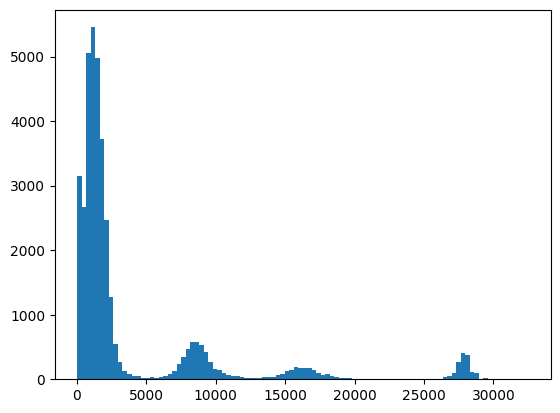

In [12]:
sizes = [len(x) for x in datasets['train']['input_ids']]
plt.hist(sizes, bins=100);